In [8]:
import sys, os, re, pickle
from collections import defaultdict
from openbabel import openbabel as ob

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

'/net/pulsar/home/koes/mtr22/gan'

In [3]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [12]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [43]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [47]:
line_idx, n_lines, pct_done

(725033, 725033, 100.0)

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


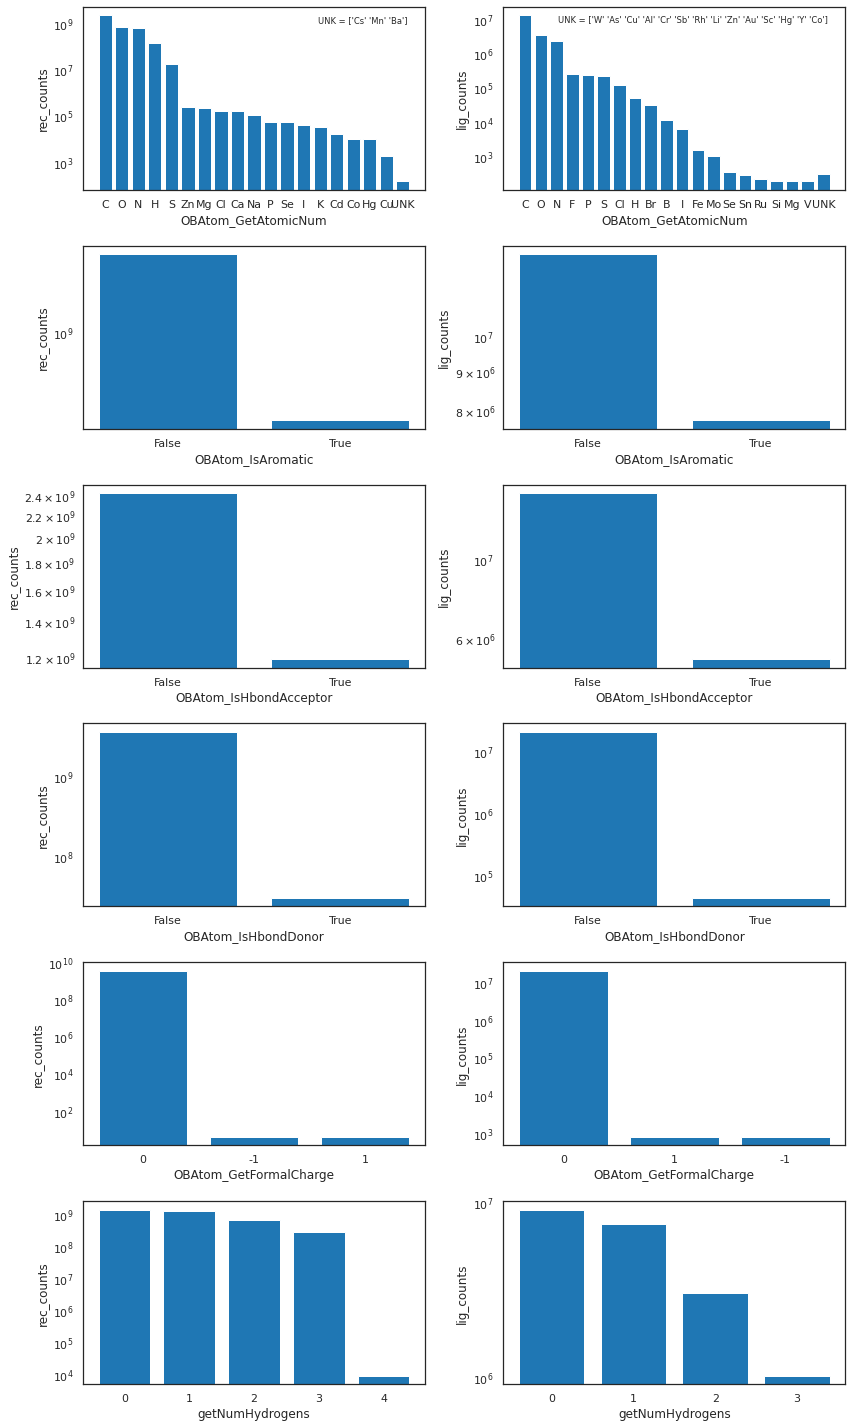

In [146]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [138]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

1	H	0.31	1.1
6	C	0.76	1.7
7	N	0.71	1.55
8	O	0.66	1.52
11	Na	1.66	2.27
12	Mg	1.41	1.73
15	P	1.07	1.8
16	S	1.05	1.8
17	Cl	1.02	1.75
19	K	2.03	2.75
20	Ca	1.76	2.31
25	Mn	1.39	2.05
27	Co	1.26	2.0
29	Cu	1.32	2.0
30	Zn	1.22	2.1
34	Se	1.2	1.9
48	Cd	1.44	2.2
53	I	1.39	1.98
55	Cs	2.44	3.43
56	Ba	2.15	2.68
80	Hg	1.32	2.05


# Bond adding experiment

In [255]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')
os.chdir(expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing'

In [259]:
add_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types',
    n_examples= 100000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
)
len(add_params)

4

In [260]:
name_format = 'add_{typer_fns}'
template_file = 'add.sh'

job_files = param_search.setup(
    expt_dir=expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oh/add.sh']

In [261]:
job_ids = param_search.submit(job_files)
print(job_ids)

[6811113, 6811114, 6811115, 6811116]


In [265]:
import pandas as pd
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

In [266]:
import numpy as np
import glob, re
import param_search

df = qstat[qstat.job_id.isin(job_ids)].copy()

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

df['work_dir'] = df.apply(find_work_dir, axis=1)
df['job_name'] = df['work_dir'].map(catch_exc(os.path.basename, TypeError))
df['job_file'] = df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
df['stdout_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
df['stderr_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
df['stdout'] = df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
df['stderr'] = df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
df['job_state'] = df.apply(find_job_state, axis=1)

In [267]:
df

,job_id,queue,job_name,user,job_state,runtime,walltime,node_id,work_dir,array_idx,job_file,stdout_file,stderr_file,stdout,stderr
169,6811113,dept_cpu,add_oad,mtr22,R,2:43,28-00:00:00,n013,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,None
170,6811114,dept_cpu,add_oadc,mtr22,R,2:43,28-00:00:00,n013,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,None
171,6811115,dept_cpu,add_on,mtr22,R,2:43,28-00:00:00,n013,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,*** Open Babel Error in TetStereoToWedgeHash
172,6811116,dept_cpu,add_oh,mtr22,R,2:43,28-00:00:00,n013,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,/net/pulsar/home/koes/mtr22/gan/new_atom_typin...,None,None


In [268]:
metrics = param_search.metrics(job_files, metric_pat='(.*)metrics')
metrics

,example_idx,lig_name,pose_idx,n_atoms_diff,type_count_diff,morgan_sim,smi_match,data_root,data_file,n_examples,typer_fns,job_name
0,0,2bq0_A_rec_5f74_amp_lig_tt_docked,0,0,12.0,0.6462,False,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oad,add_oad
1,1,4gnt_A_rec_5f74_amp_lig_it2_tt_docked,2,0,12.0,0.6462,False,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oad,add_oad
2,2,4gnt_A_rec_5f74_amp_lig_it2_tt_docked,3,0,12.0,0.6462,False,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oad,add_oad
3,3,4gnt_A_rec_5f74_amp_lig_it2_tt_docked,5,0,12.0,0.6462,False,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oad,add_oad
4,4,4gnt_A_rec_5f74_amp_lig_it2_tt_docked,6,0,11.0,0.8448,False,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oad,add_oad
...,...,...,...,...,...,...,...,...,...,...,...,...
77818,77818,5fsi_A_rec_5nhy_8xt_lig_it1_tt_docked,4,0,0.0,1.0000,True,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oh,add_oh
77819,77819,5fsi_A_rec_5nhy_8xt_lig_it1_tt_docked,5,0,0.0,1.0000,True,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oh,add_oh
77820,77820,5fsi_A_rec_5nhy_8xt_lig_it1_tt_docked,6,0,0.0,1.0000,True,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oh,add_oh
77821,77821,5fsi_A_rec_5nhy_8xt_lig_it1_tt_docked,7,0,0.0,1.0000,True,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/paf46/git/cnnaffinitypap...,100000,oh,add_oh


oad  = H acceptor/donor
oadc = H acceptor/donor + formal charge
on   = number of bonded Hs
oh   = explicit H atoms


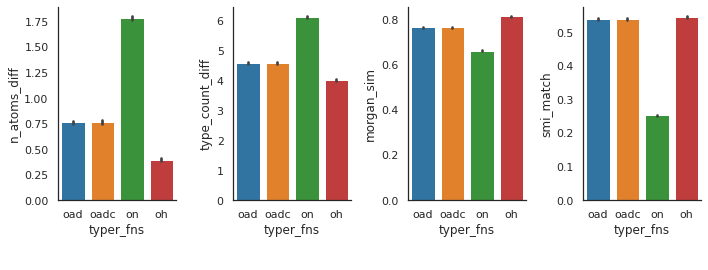

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='number of bonded Hs',
    oh  ='explicit H atoms',
)

plot_df = metrics.reset_index()

fig = param_search.plot(
    plot_df,
    x='typer_fns',
    y=[
        'n_atoms_diff',
        'type_count_diff',
        'morgan_sim',
        'smi_match'
    ],
    hue=None,
    n_cols=4,
    width=2.5,
    height=4,
    plot_func=sns.barplot
)
print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'oh']
))

In [254]:
metrics.groupby('typer_fns')[['example_idx']].count()

,example_idx
typer_fns,
oad,77823
oadc,77823
oh,2751
on,77823
